In [ ]:
# Assignment 2

In [1]:
from __future__ import division, print_function, unicode_literals
import os, sys
# sys.path.append('/home/tulsyan/apps/miniconda2/lib/python2.7/site-packages/')
# sys.path.append('/home/tulsyan/apps/miniconda2/lib/python2.7/site-packages/torchvision-0.1.9-py2.7.egg')
import xml.etree.ElementTree as ET
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as tnf
from torch.autograd import Variable
from torchvision import datasets
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from collections import namedtuple
# from matplotlib.pyplot import imshow
%matplotlib inline
# plt.ion()
# Import other modules if required

resnet_input = 224 #size of resnet18 input images

In [2]:
# Choose your hyper-parameters using validation data
Rectangle = namedtuple('Rectangle', 'xmin ymin xmax ymax')

batch_size = 10
num_epochs = 5
learning_rate =  0.005
hyp_momentum = 0.9
use_gpu = True and torch.cuda.is_available()

## Build the data
Use the following links to locally download the data:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>The dataset consists of images from 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, ie. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the given 20 classes(aeroplane, bicycle, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, train, TV). For parsing the xml file, you can import xml.etree.ElementTree for you. <br/>
<br/> Organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be 21. This is important for applying the sliding window method later.

In [3]:
classes = ('__background__', 'aeroplane', 'bicycle', 'car', 'cat', 'dog')

In [4]:
def build_dataset():
    # Begin
    folder = 'train'
    raw_image = '../datasets/' + folder + '/JPEGImages/'
    anno_image = '../datasets/' + folder + '/Annotations/'
    train_dataset = '../datasets/' + folder + '/final/'
    
    train_classes = {}
    for x in classes:
        train_classes[x] = []
        os.mkdir(os.path.join(train_dataset, x))

    for anno_filename in os.listdir(anno_image):
        tree = 	ET.parse(anno_image+anno_filename)
        root = tree.getroot()
        file_path = os.path.join(raw_image, str(root.find('filename').text))
        # print(file_path)
        img = cv2.imread(file_path)
        for i,object in enumerate(root.findall('object')):
            label = str(object.find('name').text)
            if not classes.count(label):
                continue
            bndbox = object.find('bndbox')
            xmin = int(bndbox[0].text)
            ymin = int(bndbox[1].text)
            xmax = int(bndbox[2].text)
            ymax = int(bndbox[3].text)
            crop_img = img[ymin:ymax, xmin:xmax]
            op_file_path = train_dataset + label + '/' + anno_filename.split('.')[0] + \
                                '_' + str(i) + '.jpg'
            # print(op_file_path)
            cv2.imwrite(op_file_path, crop_img)
            train_classes[label].append(crop_img)

# build_dataset()

In [5]:
class voc_dataset_train(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # Begin
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.images, self.labels = [], []
        
        if train:
            root_dir = os.path.join(root_dir, 'train/final')
        else:
            root_dir = os.path.join(root_dir, 'test')
        
        label_list = os.listdir(root_dir)
        label_list.sort()
        print (label_list)
        for label in label_list:
            label_dir = os.path.join(root_dir, label)
            label_map = classes.index(label)
            # print(label_map, len(os.listdir(label_dir)))
            for image in os.listdir(label_dir):
                self.images += [os.path.join(label_dir, image)]
                self.labels += [label_map]
        
    def __len__(self):
        # Begin
        return len(self.images)
        
    def __getitem__(self, idx):
        # Begin
        img = Image.open(self.images[idx])
        img = self.transform(img)
        return (img, self.labels[idx])

In [6]:
class custom_dataset_test(object):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.idx_to_serve = 0
        self.annots = []
        self.bndbox_pts = ['xmin','ymin','xmax','ymax']
        
        self.root_dir = os.path.join(root_dir, 'test')
        self.image_dir = os.path.join(self.root_dir, 'JPEGImages')
        self.annot_dir = os.path.join(self.root_dir, 'Annotations')
        
        annot_list = os.listdir(self.annot_dir)
        # print(len(annot_list))
        annot_list.sort()
        for annot_fname in annot_list:
            self.annots += [os.path.join(self.annot_dir, annot_fname)]
            
    def get_len(self):
        return len(self.annots)
    
    def reset_idx(self):
        self.idx_to_serve = 0
    
    def get_next_img(self):
        ret_tup = self.get_img(self.idx_to_serve)
        self.idx_to_serve = 1 + self.idx_to_serve
        return ret_tup
        
    def get_img(self, idx):
        if idx >= self.get_len():
            return None
        
        annot_tree = ET.parse(self.annots[idx])
        root = annot_tree.getroot()
        local_annot = []
        for obj in root.findall('object'):
            label = obj.find('name').text
            if str(label) in classes:
                bndbox = obj.find('bndbox')
                local_annot += [(classes.index(label), [int(bndbox.find(pt).text) for pt in self.bndbox_pts])]
        local_annot.sort(key=lambda tup: tup[0])
        
        img = Image.open(os.path.join(self.image_dir, str(root.find('filename').text)))
        if self.transform:
            img = self.transform(img)
        
        return (img, local_annot)

## Train the netwok
<br/>You can train the network on the created dataset. This will yield a classification network on the 21 classes of the VOC dataset. 

[u'__background__', u'aeroplane', u'bicycle', u'car', u'cat', u'dog']

 1
 0
 1
 3
 0
 3
 0
 1
 3
 3
[torch.LongTensor of size 10]

[(5, [48, 240, 195, 371])]


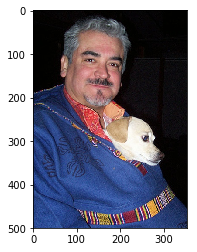

In [7]:
composed_transform = transforms.Compose([transforms.Scale((resnet_input, resnet_input)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor()])

composed_transform_test = transforms.Compose([transforms.RandomHorizontalFlip()])
composed_transform_test2 = transforms.Compose([transforms.Scale((resnet_input, resnet_input)),
                                              transforms.ToTensor()
                                              ])

dataset_dir = '../datasets/'
train_dataset = voc_dataset_train(root_dir=dataset_dir, train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = custom_dataset_test(root_dir=dataset_dir, transform=composed_transform_test)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# # Let's look at one batch of train and test images
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

train_dataiter = iter(train_loader)
train_images, train_labels = train_dataiter.next()
# print("Train images")
print(train_labels)
imshow(torchvision.utils.make_grid(train_images))

test_image, test_label = test_dataset.get_img(0)
print(str(test_label))
tensor_img = transforms.Compose([transforms.ToTensor()])(test_image)
imshow(tensor_img)

### Fine-tuning
Use the pre-trained network to fine-tune the network in the following section:

In [8]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, len(classes))

if use_gpu:
    resnet18 = resnet18.cuda()

# Add code for using CUDA here

In [9]:
criterion = nn.CrossEntropyLoss()
# Update if any errors occur
optimizer = torch.optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)

In [ ]:
def train():
    # Begin
    loss_store = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if (use_gpu):
                images = images.cuda()
                labels = labels.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()    
            
            running_loss += loss.data[0]
            
            if (i+1)%10 == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
        loss_store += [running_loss]

    plt.plot(loss_store)
    plt.title("Sum of Loss over subsequent epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Sum of loss")
    plt.show()

In [ ]:
%time train()

Epoch [1/5], Step [10/412], Loss: 0.9938
Epoch [1/5], Step [20/412], Loss: 0.7973
Epoch [1/5], Step [30/412], Loss: 0.5316
Epoch [1/5], Step [40/412], Loss: 0.9413
Epoch [1/5], Step [50/412], Loss: 0.5825
Epoch [1/5], Step [60/412], Loss: 1.1539
Epoch [1/5], Step [70/412], Loss: 2.3030
Epoch [1/5], Step [80/412], Loss: 1.4465
Epoch [1/5], Step [90/412], Loss: 1.0223
Epoch [1/5], Step [100/412], Loss: 0.8929
Epoch [1/5], Step [110/412], Loss: 2.2492
Epoch [1/5], Step [120/412], Loss: 0.5934
Epoch [1/5], Step [130/412], Loss: 0.3224
Epoch [1/5], Step [140/412], Loss: 2.3506
Epoch [1/5], Step [150/412], Loss: 0.3684
Epoch [1/5], Step [160/412], Loss: 0.8328
Epoch [1/5], Step [170/412], Loss: 1.4136
Epoch [1/5], Step [180/412], Loss: 1.2071
Epoch [1/5], Step [190/412], Loss: 0.9011
Epoch [1/5], Step [200/412], Loss: 0.4293
Epoch [1/5], Step [210/412], Loss: 3.6275
Epoch [1/5], Step [220/412], Loss: 1.2327
Epoch [1/5], Step [230/412], Loss: 0.5178
Epoch [1/5], Step [240/412], Loss: 0.4661
E

In [14]:
torch.save(resnet18.state_dict(), 'resnet18_model.pkl')
# resnet18.load_state_dict(torch.load('resnet18_model.pkl'))

# Testing and Accuracy Calculation
For applying detection, use a slding window method to test the above trained trained network on the detection task:<br/>
Take some windows of varying size and aspect ratios and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value. There is a similar approach used in the paper -Faster RCNN by Ross Girshick, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide. You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [15]:
def sliding_window(img, step_size=16, window_size=(64,64)):
    # Begin
    pad_updown, pad_side = window_size[0]//2, window_size[1]//2
    old_size = img.size
    new_size = (old_size[0]+window_size[0], old_size[1]+window_size[1])
    new_img = Image.new("RGB", new_size)
    new_img.paste(img, (pad_updown, pad_side))
    
    # plt.imshow(new_img)
    # new_img.show()
    # print(new_size)
    arr = []
    for y in range(pad_updown, new_size[0]-pad_updown, step_size):
        for x in range(pad_side, new_size[1]-pad_side, step_size):
            # print(x,y)
            cropped_img = new_img.crop((x, y, x+window_size[0], y+window_size[1]))
            arr.append([[x, y, x + window_size[0]-1, y + window_size[1]-1], 
                        composed_transform_test2(cropped_img)])
    return arr

# img, lab = test_dataset.get_img(0)
# tmp = sliding_window(img)
# arr = [x[1] for x in tmp]
# imshow(torchvision.utils.make_grid(arr[:100]))

Apply non_maximum_supression to reduce the number of boxes. You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [1]:
def non_maximum_supression(boxes, threshold=0.3):
    # Begin
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # initialize the list of picked indexes
    pick = []

    # grab the coordinates of the bounding boxes
    scores = boxes[:,0]
    x1 = boxes[:,1]
    y1 = boxes[:,2]
    x2 = boxes[:,3]
    y2 = boxes[:,4]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)
    
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list, add the index
        # value to the list of picked indexes, then initialize
        # the suppression list (i.e. indexes that will be deleted)
        # using the last index
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        suppress = [last]
        
        # loop over all indexes in the indexes list
        for pos in xrange(0, last):
            # grab the current index
            j = idxs[pos]

            # find the largest (x, y) coordinates for the start of
            # the bounding box and the smallest (x, y) coordinates
            # for the end of the bounding box
            xx1 = max(x1[i], x1[j])
            yy1 = max(y1[i], y1[j])
            xx2 = min(x2[i], x2[j])
            yy2 = min(y2[i], y2[j])

            # compute the width and height of the bounding box
            w = max(0, xx2 - xx1 + 1)
            h = max(0, yy2 - yy1 + 1)

            # compute the ratio of overlap between the computed
            # bounding box and the bounding box in the area list
            intersection = float(w * h)
            overlap = intersection / (area[j] + area[i] - intersection)

            # if there is sufficient overlap, suppress the
            # current bounding box
            if overlap > threshold:
                suppress.append(pos)

        # delete all indexes from the index list that are in the
        # suppression list
        idxs = np.delete(idxs, suppress)

    # return only the bounding boxes that were picked
    return boxes[pick]

In [17]:
def filter_get_tensor(tensor_list):
    nlist = []
    for img_tup in tensor_list:
        nlist += [img_tup[1]]
    
    to_tensor = torch.cat(nlist[:], 1)
    return to_tensor.resize_(len(nlist), 3, resnet_input, resnet_input)

In [ ]:
def area_intersection(a, b):  # returns None if rectangles don't intersect
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy

def area(a):
    dx = a.xmax - a.xmin
    dy = a.ymax - a.ymin
    return dx*dy

def intersection_over_union(rect1, rect2):
    intersect_area = area_intersection(rect1, rect2)
    if intersect_area == None:
        intersect_area = 0
    total_area = area(rect1) + area(rect2) - intersect_area
    return intersect_area/total_area

Test the trained model on the test dataset.

In [57]:
def test(resnet18, threshold_score=20.0, map_iou_threshold=0.5):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model
    # for ind in xrange(test_dataset.get_len()):
    mmap = 0
    for ind in xrange(1):
        img, anno = test_dataset.get_img(ind)
        
        pred = []
        for x in xrange(len(classes)):
            pred += [[]]
        test_batch = 20
        for side1 in [64,128,256]:
            for ratio in [0.5,1,2.0]:
                windows = sliding_window(img=img, window_size=(side1,int(side1*ratio)))
                print(len(windows))

                w_ind, w_lim = 0, len(windows)
                while w_ind < w_lim:
                    my_inp = filter_get_tensor(windows[w_ind:w_ind+test_batch])
                    # imshow(torchvision.utils.make_grid(my_inp[0:2]))
                    # print(my_inp.size())

                    my_inp = Variable(my_inp)
                    if use_gpu:
                        my_inp = my_inp.cuda()
                    output = resnet18(my_inp) # matrix of size nx6, where n <= test_batch
                    # print(output)

                    for inp in xrange(output.size()[0]):
                        for op_label in xrange(1, len(classes)):
                            if threshold_score < (output.data)[inp][op_label]:
                                pred[op_label] += [[(output.data)[inp][op_label]] + windows[w_ind+inp][0]]

                    w_ind += test_batch
                    
        output_classes = [[]]
        anno_classes = [[]]
        for i in xrange(1,6):
            output_classes.append([])
            anno_classes.append([])
            # print('Prediction for label ', i, pred[i])
            output_classes[i].append(non_maximum_supression(np.array(pred[i]))[1:])
        
        for i, temp in enumerate(anno):
            anno_classes[anno[i][0]].append((anno[i][1][0], anno[i][1][1], anno[i][1][2], anno[i][1][3]))
            
        flag = False
        no_of_classes = 0
        mean_average_precision = 0
        for i, temp1 in enumerate(anno_classes):
            average_precision = 0
            if len(anno_classes[i]) > 0:
                for j, temp2 in enumerate(output_classes[i]):
                    flag = False
                    seen = 0
                    approved = 0
                    for k, temp3 in enumerate(anno_classes[i]):
                        iou = intersection_over_union(Rectangle(anno_classes[i][k][0], anno_classes[i][k][1], anno_classes[i][k][2], anno_classes[i][k][3]),
                                                     Rectangle(output_classes[i][j][0], output_classes[i][j][1], output_classes[i][j][2], output_classes[i][j][3]))
                        if iou > iou_thresh:
                            flag = True
                            break
                    seen = seen + 1
                    if flag == True:
                        approved = approved + 1
                        precision = precision + approved/seen
                average_precision = precision/approved
                mean_average_precision = mean_average_precision + average_precision
                no_of_classes = no_of_classes + 1
        mean_average_precision = mean_average_precision/no_of_classes
        mmap = mmap + mean_average_precision
    
    mmap = mmap / count
    print("MMAP:", mmap)
            

In [29]:
%time pred=test(resnet18)

736
736
736
736
736
736
736
736
736
CPU times: user 1min 52s, sys: 20.5 s, total: 2min 12s
Wall time: 2min
